# Generated Content Detector Project: AI generated photos vs real photos
## Pytorch CNN model - Version 1





### Import libraries

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import os
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
print(torch.cuda.is_available())
from PIL import Image

True


### Determine System Device to optimize performance: CPU or CUDA (VRAM) Checker

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


### Image Dataset Preparation with PyTorch
##### - Training Data: 1,600 images (800 AI + 800 real) - 80%
##### - Testing Data: 400 images (200 AI + 200 real) - 20%

In [29]:
%%time
# --- 1. Define transforms ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- 2. Load dataset structure ---
dataset = datasets.ImageFolder("/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/AI-face-detection-Dataset/", transform=transform)

# dataset.class_to_idx → {'ai': 0, 'real': 1}

# --- 3. Split by class (real + ai separately) ---
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 80%
def split_class(indices, train_ratio=0.8):
    train_len = int(len(indices) * train_ratio)
    return indices[:train_len], indices[train_len:]

train_real, test_real = split_class(indices_real)
train_ai,   test_ai   = split_class(indices_ai)

# --- 4. Combine indices for train & test ---
train_indices = train_real + train_ai
test_indices  = test_real + test_ai

train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

# --- 5. Dataloaders ---
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader  = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# --- 6. Class names ---
classes = dataset.classes   # ['ai', 'real']

print("Train samples:", len(train_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

Train samples: 1600
Test samples: 401
Classes: ['AI', 'real_color']
CPU times: user 21 s, sys: 628 ms, total: 21.6 s
Wall time: 34.6 s


### Display Randomly Selected Images with Classifications from the Trained Model

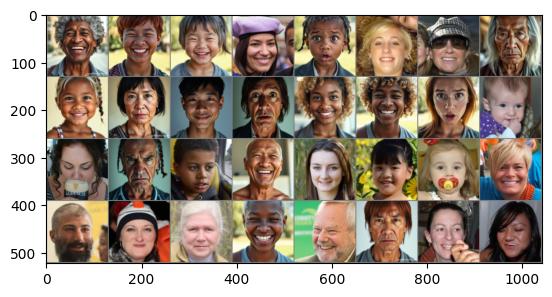

AI    AI    AI    real_color AI    real_color real_color AI   


In [30]:
# functions to show an image
batch_size = 8
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network (CNN) for Image Classification
##### This code implements a convolutional neural network (CNN) class named Net, featuring two convolutional layers with pooling, followed by three fully connected layers. It is designed for binary image classification, effectively modeling the forward pass to process input images and output class predictions.

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Flattened size: 16 channels * 29 * 29
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Corrected output size for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# net = Net()             #CPU
net = Net().to(device)    #GPU


### Setting Up the Loss Function and Optimizer


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Training the Neural Network
##### This section of the code trains the neural network for 100 epochs, calculating and recording the training loss at each epoch. It utilizes a data loader to iterate through the training dataset, performs forward and backward passes, and updates the model weights using the defined optimizer.

In [33]:
%%time
train_losses = []

for epoch in range(100):
    running_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, loss: {epoch_loss}")

print("Finished Training")

Epoch 1, loss: 0.6631123089790344
Epoch 2, loss: 0.3582327476143837
Epoch 3, loss: 0.05479006564244628
Epoch 4, loss: 0.019879889227449894
Epoch 5, loss: 0.011075669846031816
Epoch 6, loss: 0.011242838263278827
Epoch 7, loss: 0.008035714346624446
Epoch 8, loss: 0.0046175925992429255
Epoch 9, loss: 0.0038075857382500545
Epoch 10, loss: 0.0038449382927501575
Epoch 11, loss: 0.0022756276458676438
Epoch 12, loss: 0.002465480633400148
Epoch 13, loss: 0.0019248842968954704
Epoch 14, loss: 0.0016557641909457743
Epoch 15, loss: 0.0014240303511178353
Epoch 16, loss: 0.0011838815252485802
Epoch 17, loss: 0.0011185855865551275
Epoch 18, loss: 0.0010576128669345054
Epoch 19, loss: 0.0009714206747048592
Epoch 20, loss: 0.0009235208371319458
Epoch 21, loss: 0.0008652606892792391
Epoch 22, loss: 0.0007730503562925151
Epoch 23, loss: 0.0007081504551752004
Epoch 24, loss: 0.0007197292710043258
Epoch 25, loss: 0.0006668893664391362
Epoch 26, loss: 0.0006176780914756818
Epoch 27, loss: 0.0005749699460284

### Visualizing Training Results: Improved Performance Across Epochs


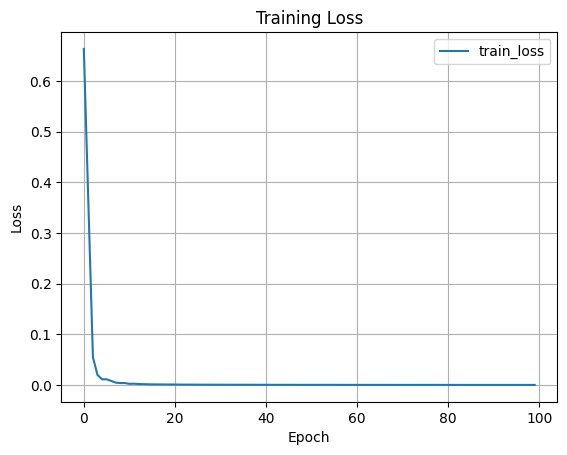

In [34]:
def plot_history(train_losses):
    plt.figure()
    plt.plot(train_losses, label="train_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming 'train_losses' list is available from previous training cell (e.g., b00LhdtfaTOQ)
if 'train_losses' in globals() and train_losses:
    plot_history(train_losses)
else:
    print("Error: 'train_losses' not found or is empty. Please run the training cell first.")

### Saving the Trained Model



In [35]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net_2.pth'
torch.save(net.state_dict(), PATH)

### Testing the Network on Test Data





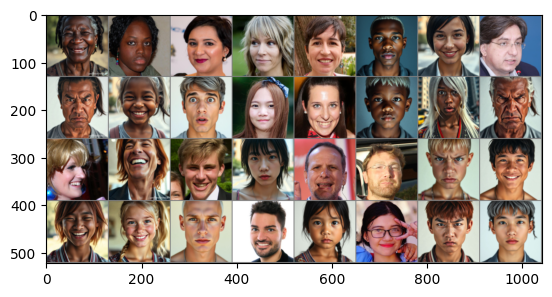

GroundTruth:  AI    real_color real_color real_color real_color AI    AI    real_color


In [36]:
dataiter = iter(testloader)
print(dataiter)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

### Loading the Saved Model and Summary of Architecture
##### It highlights that the model has approximately 1.63 million trainable parameters, details the output shapes of each layer, and indicates an estimated total model size of about 6.21 MB. This information is essential for understanding the model's complexity and resource requirements.

In [37]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net_2.pth'
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device) # Move the model to the GPU

summary(net, (3, 128, 128)) # Corrected input size for summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
         MaxPool2d-2            [-1, 6, 62, 62]               0
            Conv2d-3           [-1, 16, 58, 58]           2,416
         MaxPool2d-4           [-1, 16, 29, 29]               0
            Linear-5                  [-1, 120]       1,614,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 1,628,046
Trainable params: 1,628,046
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.39
Params size (MB): 6.21
Estimated Total Size (MB): 7.79
----------------------------------------------------------------


### Interpreting Model Outputs: Class Predictions
##### The outputs from the model represent energy levels for two classes, indicating the network's confidence in classifying an image. A higher energy value suggests a stronger belief that the image belongs to that specific class.

In [38]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  AI    AI    real_color AI   


### Evaluating Network Performance on the Entire Dataset

In [39]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 400 test images: {100 * correct // total} %')

Accuracy of the network on the 400 test images: 100 %


In [40]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: AI    is 100.0 %
Accuracy for class: real_color is 100.0 %


###### NOTE: The evaluation indicates that the network has achieved 100% accuracy on the entire dataset, which is likely due to overfitting since dataset is small and not diverse.

### Evaluating Model Performance on an Out-of-Dataset Images:

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image # Add this import statement
import numpy as np
import os

# Step 1: Define the EXACT model architecture from training
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.conv2 = nn.Conv2d(6, 16, 5)  # Second convolutional layer
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # First fully connected layer
        self.fc2 = nn.Linear(120, 84)  # Second fully connected layer
        self.fc3 = nn.Linear(84, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply first conv layer and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply second conv layer and pooling
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # Forward pass through first fully connected layer
        x = F.relu(self.fc2(x))  # Forward pass through second fully connected layer
        x = self.fc3(x)  # Output layer
        return x

# Step 2: Load the trained model
def load_model(model_path, device='cpu'):
    """Load the trained model from .pth file"""
    model = Net().to(device)  # Initialize model and move to specified device
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load the model's weights
    model.eval()  # Set the model to evaluation mode
    return model

# Step 3: Preprocess the image (CRITICAL: Must be 128x128!)
def preprocess_image(image_path, target_size=(128, 128)):
    """Load and preprocess a single image"""
    transform = transforms.Compose([
        transforms.Resize(target_size),  # Resize image to target size
        transforms.ToTensor(),           # Convert image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
    ])

    image = Image.open(image_path).convert('RGB')  # Open and convert image to RGB
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Step 4: Make prediction
def predict(model, image_tensor, device='cpu'):
    """Run inference on the preprocessed image"""
    image_tensor = image_tensor.to(device)  # Move tensor to the appropriate device

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image_tensor)  # Get model outputs
        probabilities = torch.softmax(outputs, dim=1)  # Convert outputs to probabilities
        predicted_class = torch.argmax(probabilities, dim=1)  # Get the predicted class index

    return predicted_class.item(), probabilities[0].cpu().numpy()  # Return predictions

# Step 5: Main testing function for the folder of images
def test_image_folder(model_path, image_folder, class_labels=None, device=None):
    """Complete pipeline to test model on a folder of images and count predictions"""
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    if class_labels is None:
        class_labels = {
            0: "AI-Generated",  # AI
            1: "Real Photo",  # Real
        }

    print(f"Loading model from {model_path}...")
    model = load_model(model_path, device)

    # Counters for predictions
    ai_generated_count = 0
    real_photo_count = 0

    # Loop through all images in the specified folder
    for image_file in os.listdir(image_folder):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.avif')):  # Check for valid image extensions
            image_path = os.path.join(image_folder, image_file)
            print(f"Processing image: {image_path}")

            image_tensor = preprocess_image(image_path)

            print("Running inference...")
            predicted_class, probabilities = predict(model, image_tensor, device)

            # Count predictions
            if predicted_class == 0:  # AI-Generated
                ai_generated_count += 1
            elif predicted_class == 1:  # Real Photo
                real_photo_count += 1

    # Display the total counts of predictions
    print("\n" + "="*60)
    print("TOTAL PREDICTIONS:")
    print("="*60)
    print(f"Total AI-Generated Photos: {ai_generated_count}")
    print(f"Total Real Photos: {real_photo_count}")
    print("="*60)

# Example usage
if __name__ == "__main__":
    CLASS_LABELS = {
        0: "AI-Generated",  # AI
        1: "Real Photo",    # Real
    }

    MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net_2.pth"
    IMAGE_FOLDER = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/photos_outside_dataset/ai_outside_dataset"

    try:
        test_image_folder(MODEL_PATH, IMAGE_FOLDER, class_labels=CLASS_LABELS)

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please check that the model and image folder paths are correct.")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

Using device: cuda
Loading model from /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net_2.pth...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/photos_outside_dataset/ai_outside_dataset/ai4.jpg
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/photos_outside_dataset/ai_outside_dataset/ai5.jpg
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/photos_outside_dataset/ai_outside_dataset/ai6.avif
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/photos_outside_dataset/ai_outside_dataset/ai7.jpg
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/photos_outside_dataset/ai_outside_dataset/ai8.avif
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/photos_outside_dataset/ai_ou

#### SUMMARY: The evaluation indicated that the model faced significant challenges in accurately classifying AI-generated photos from an external dataset, misidentifying 29 out of 32 images as real. This underscores the importance of expanding and diversifying the dataset to enhance the model's capability to distinguish effectively between AI-generated and real images. By incorporating a wider variety of examples, I can significantly improve the model’s robustness and accuracy.